# Exercise: Building a light curve from two different sectors.

## Goal

Some targets in TESS will have data in multiple sectors. These targets can be combined using lightkurve into one data set, and then analyzed together. In this exercise, you'll combine the data from sectors 1 and 4 for *Pi Mensae c* and improve the signal to noise of the transit detection. 

### Merging two light curves from two sectors.

In our previous exercise we created different apertures using light curve. Use the same methods to create download TPFs plot two aperture masks.

In [38]:
import lightkurve as lk
tpfs = lk.search_targetpixelfile('Pi Mensae').download_all()

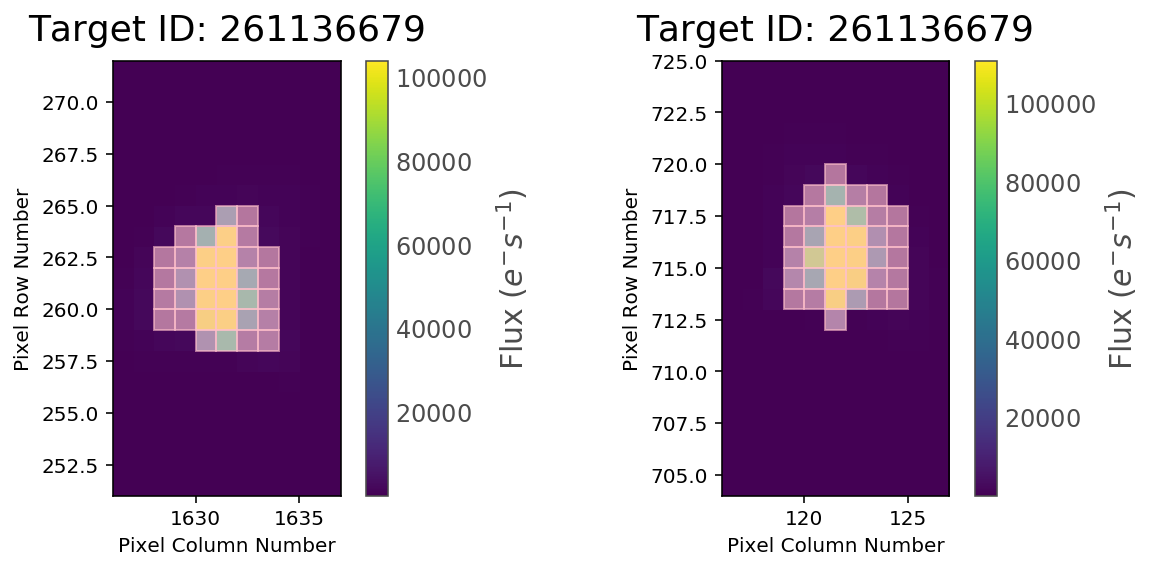

In [173]:
# Using matplotlib.pyplot's subplots method we can create a plot that has three panels 
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for idx, tpf in enumerate(tpfs):
    aper = tpf.create_threshold_mask(10)
    tpf.plot(aperture_mask=aper, ax=axs[idx])

**Note:** The two tpfs have slightly different PSF shapes, due to being on different parts of the detector, at different seasons, with different scattered light. If you plot the TPFs you will see that you cannot simply reuse the same aperture for different sectors.

Create light curves from each TPF, using the `to_lightcurve` method, and plot them.

In [174]:
aper = tpfs[0].create_threshold_mask(50)
lc1 = tpfs[0].to_lightcurve(aperture_mask=aper)

aper = tpfs[1].create_threshold_mask(50)
lc2 = tpfs[1].to_lightcurve(aperture_mask=aper)

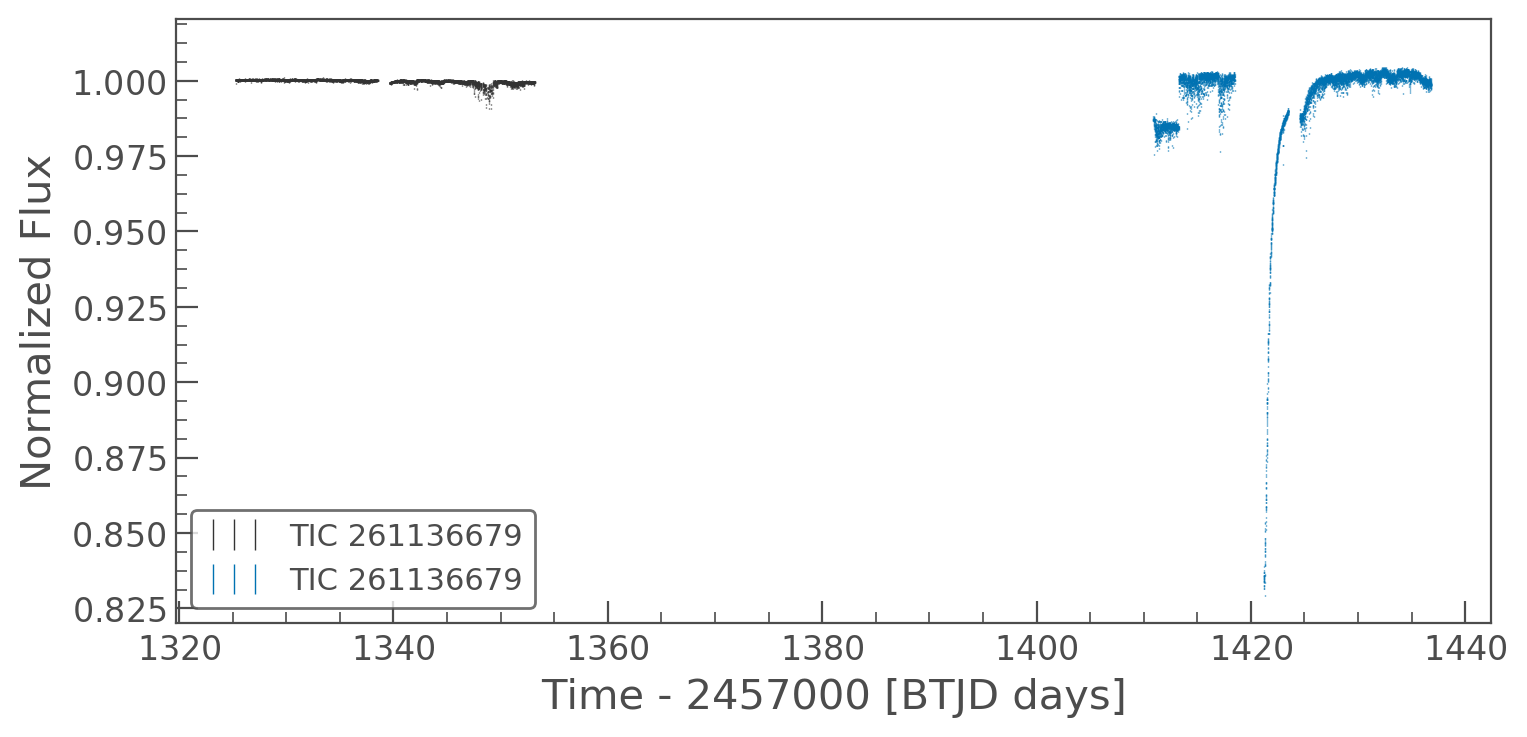

In [175]:
ax = lc1.errorbar()
lc2.errorbar(ax=ax)

You should see that in sector 4, the target moves significantly in the middle of the exposure. This causes a large flux loss. (You can also see this using the `tpf.interact()` tool). This large flux loss can be dealt with in a few ways, but today we are going to remove this portion of the light curve.

### Trimming out bad data

Use the `tpf.estimate_centroids()` method to plot the motion of the target during sector 4. Plot the motion in $x$ against the motion in $y$. Choose a cut off value in $x$ or $y$ that preserves the data mostly around $x = 0,\; y = 0$

Text(-0.6,-0.02,'Cut Off')

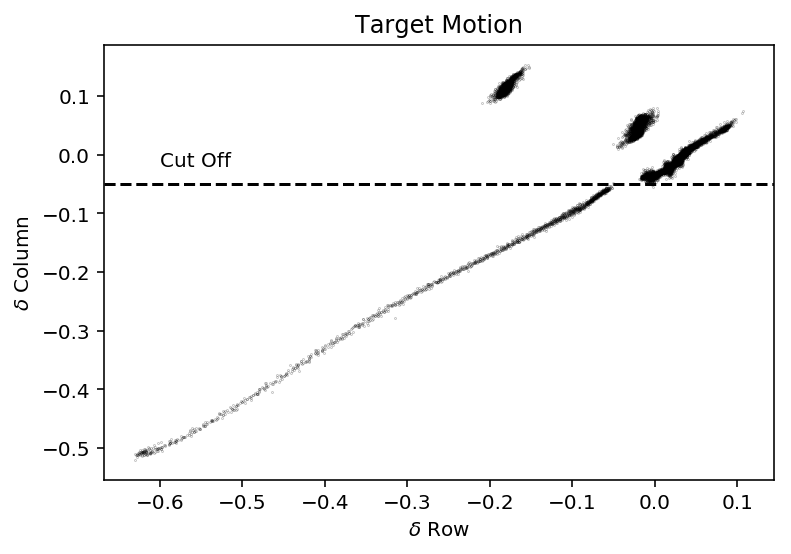

In [176]:
import numpy as np
r, c = tpfs[1].estimate_centroids()
r -= np.nanmedian(r)
c -= np.nanmedian(c)
plt.scatter(r, c, s=0.01, c='k')
plt.axhline(-0.05, c='k', ls='--')
plt.xlabel('$\delta$ Row')
plt.ylabel('$\delta$ Column')
plt.title('Target Motion')
plt.text(-0.6, -0.02, 'Cut Off')

With your new cut off value, mask the tpf so that only those cadences where the motion is small are preserved. Plot the light curve and compare to the unmasked tpf, and confirm that the bad data has been removed.

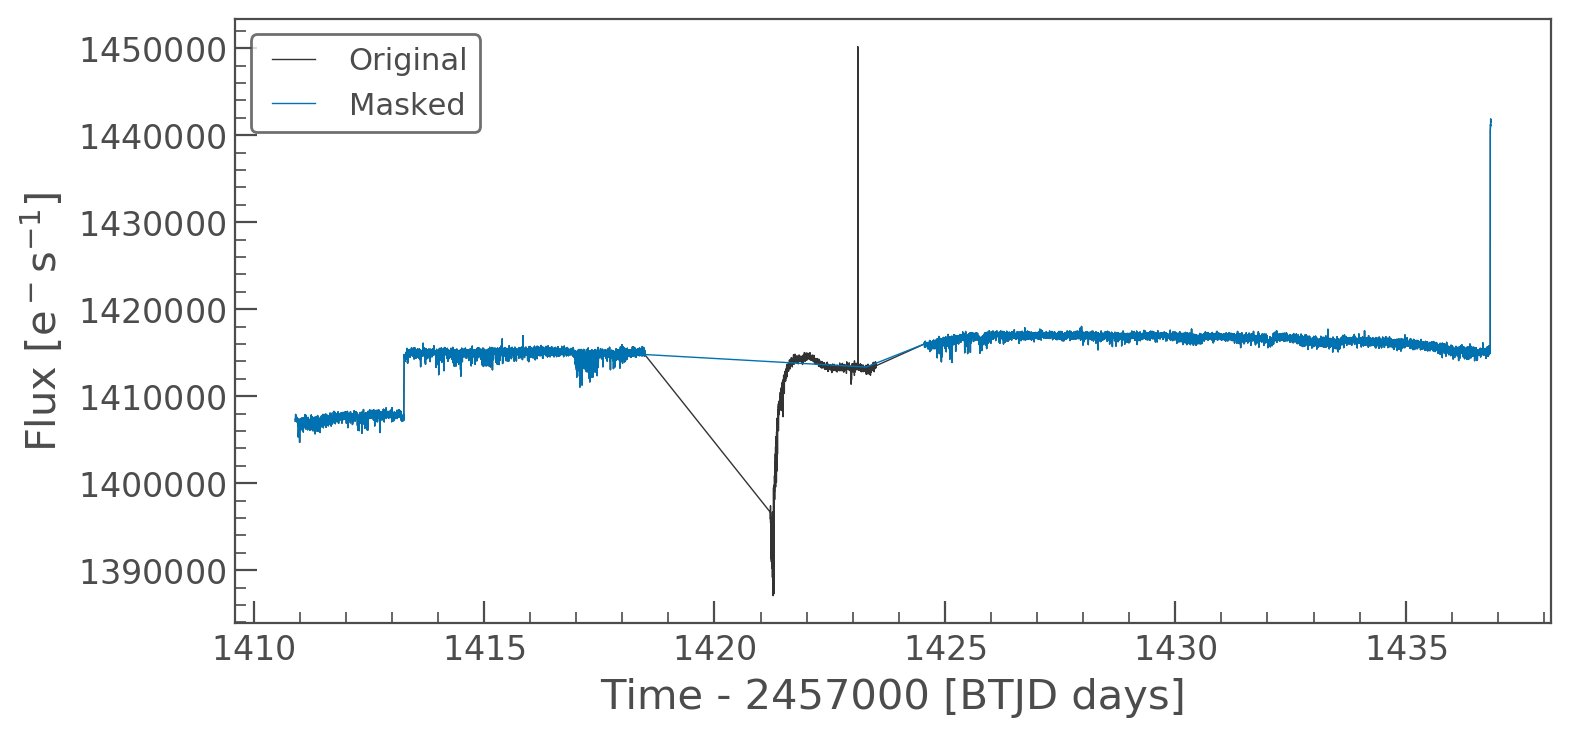

In [177]:
mask = c > -0.05
ax = tpfs[1].to_lightcurve().plot(normalize=False, label='Original');
tpfs[1][mask].to_lightcurve().plot(ax=ax, normalize=False, label='Masked');

Now that we have a masked tpf, regenerate your aperture mask for this target. By removing bad cadences, we should improve out aperture estimate.

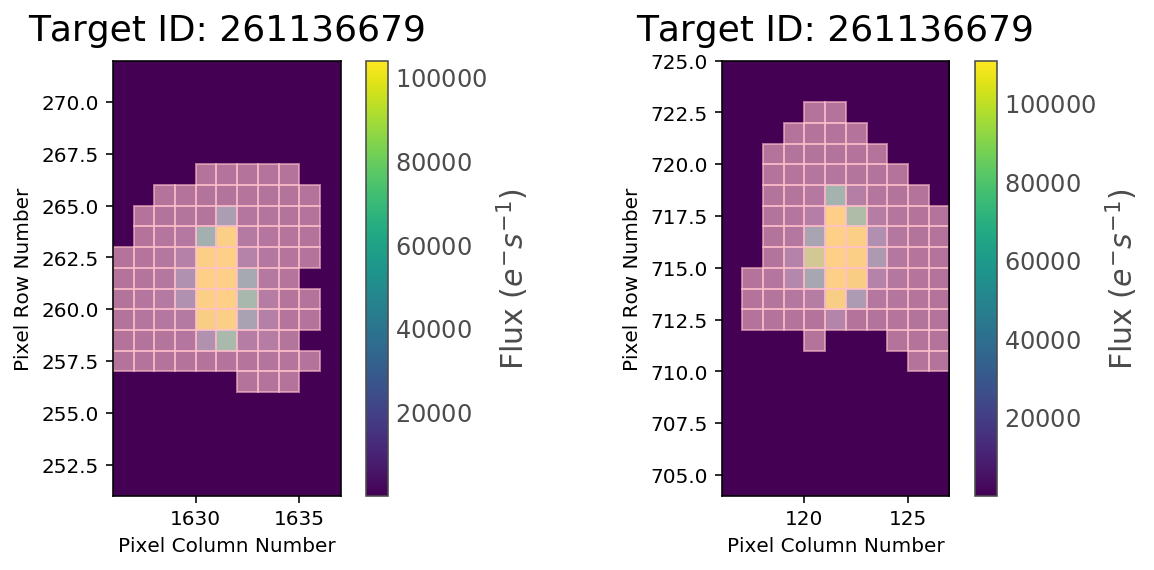

In [182]:
# Using matplotlib.pyplot's subplots method we can create a plot that has two panels 
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

aper1 = tpfs[0].create_threshold_mask(1)
tpfs[0].plot(aperture_mask=aper1, ax=axs[0])

aper2 = tpfs[1][mask].create_threshold_mask(1)
tpfs[1].plot(aperture_mask=aper2, ax=axs[1])

Use the `tpf.to_lightcurve()` method to create two light curves from each of these apertures.

In [183]:
lc1 = tpfs[0].to_lightcurve(aperture_mask=aper1)
lc2 = tpfs[1][mask].to_lightcurve(aperture_mask=aper2)

Use the `lc.flatten()` method, `lc.remove_outliers()` method and masking to remove the long term trends, outlier and any sections of the light curve with poor data quality. Plot the light curves to visually inspect them.

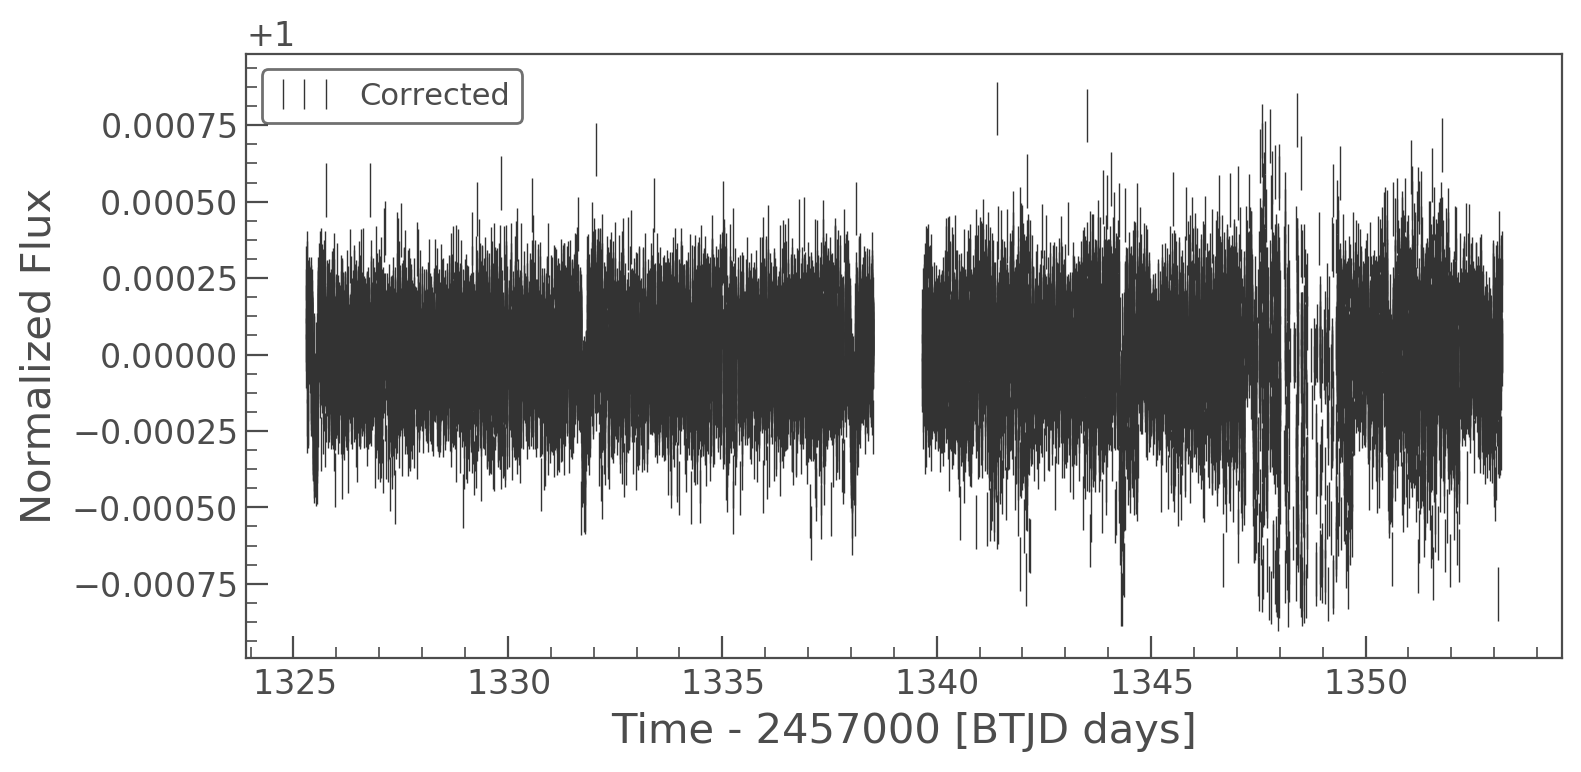

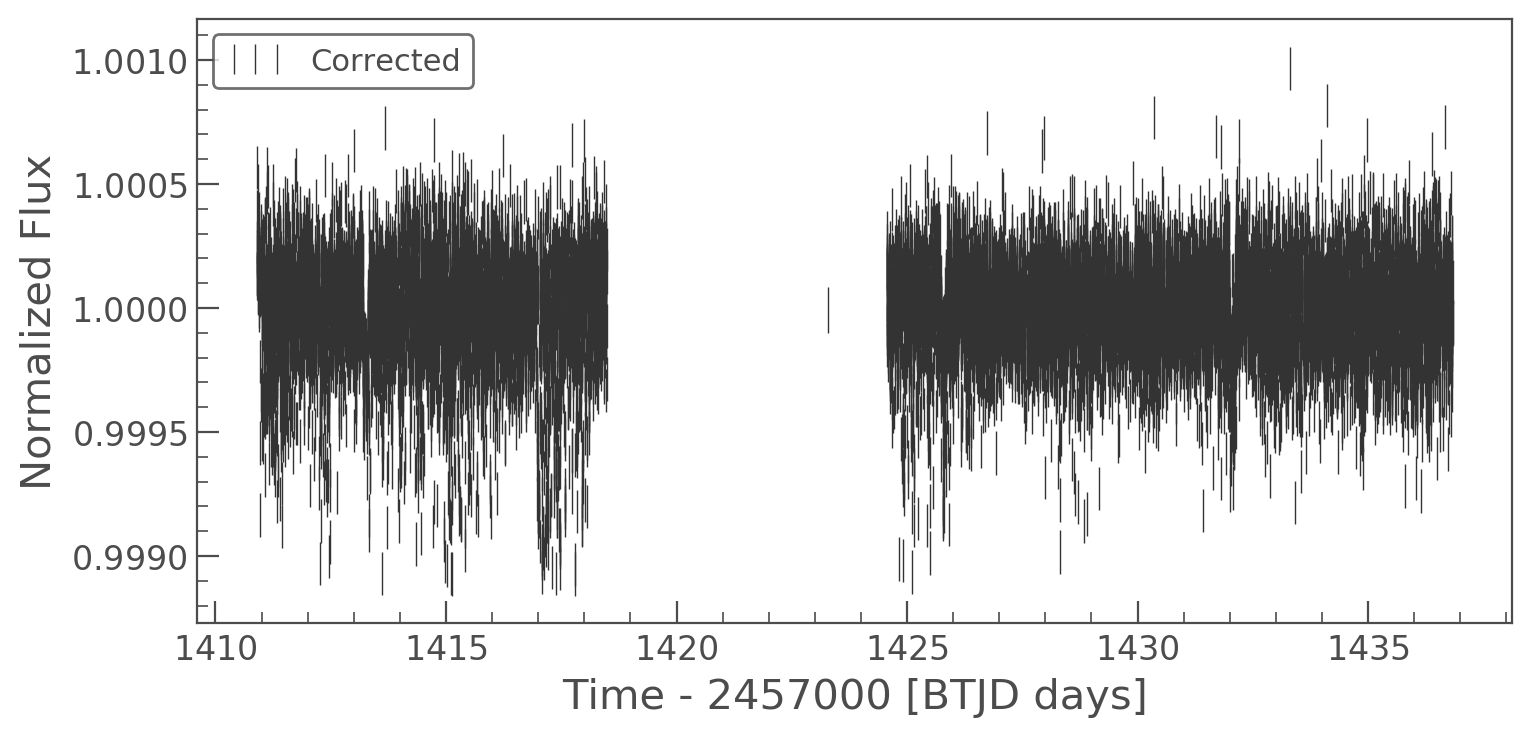

In [190]:
corr1 = lc1.flatten(1001, break_tolerance=10).remove_outliers(5)
corr1.errorbar(label='Corrected')

corr2 = lc2.flatten(1001, break_tolerance=10).remove_outliers(5)
corr2.errorbar(label='Corrected')

Use the `lc.append()` method to create a new `LightCurve` object from the two separate sectors. The syntax here is

```python
new_lc = lc1.append(lc2)
```

**Note:** Be careful to use the `normalize()` method on each light curve, in order to set the median flux of each light curve to 1. Otherwise, you will end up with two sectors with a slight offset in flux.

In [191]:
lc = corr1.normalize().append(corr2.normalize())

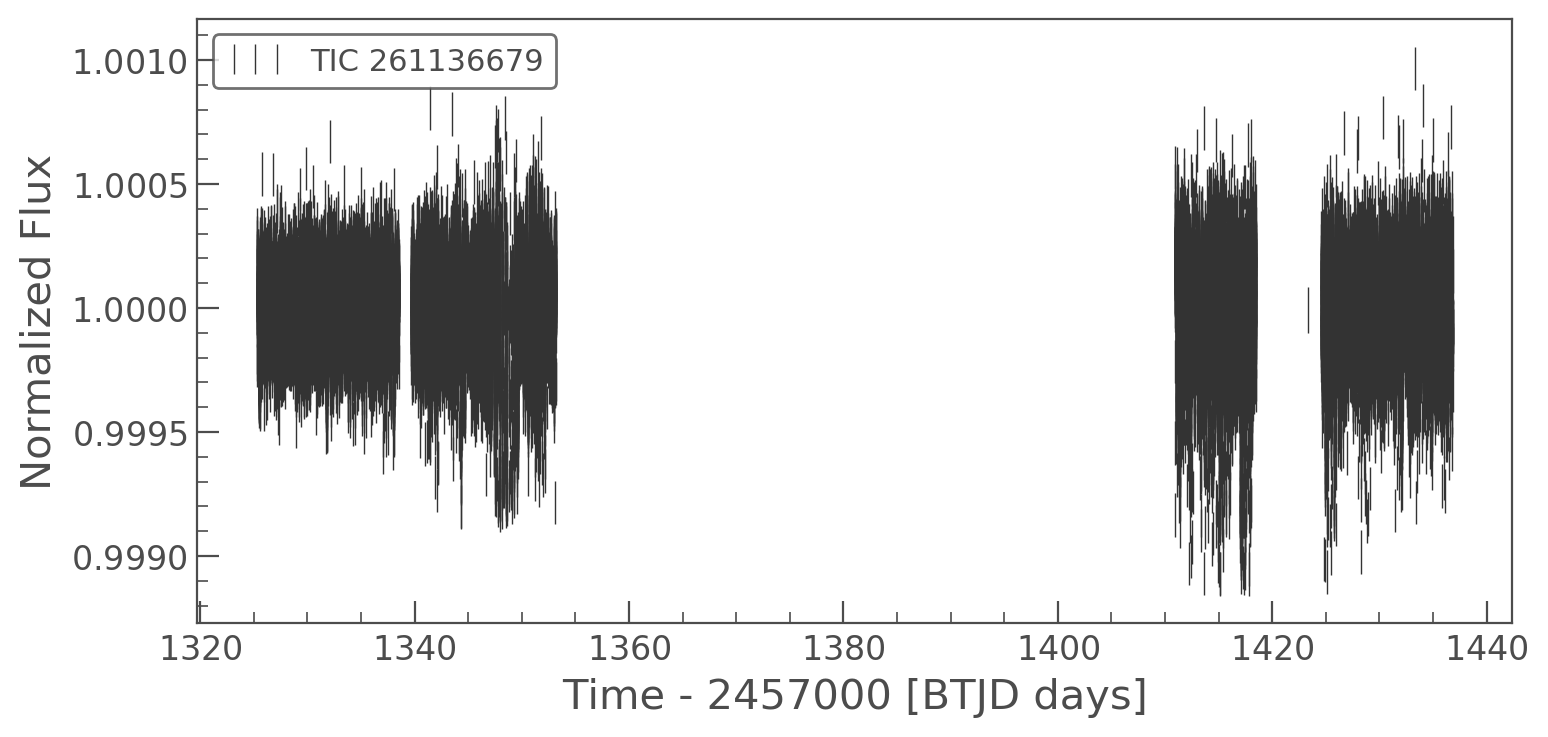

In [192]:
lc.errorbar()

Use the `fold()` method and `bin()` method to show the folded transit of *Pi Mensae c* for sector 1, sector 4 and combined.

**Hint: ** The period and transit midpoint of *Pi Mensae c* is:
* period = 6.27
* t0 = 1325.504 

(-0.1, 0.1)

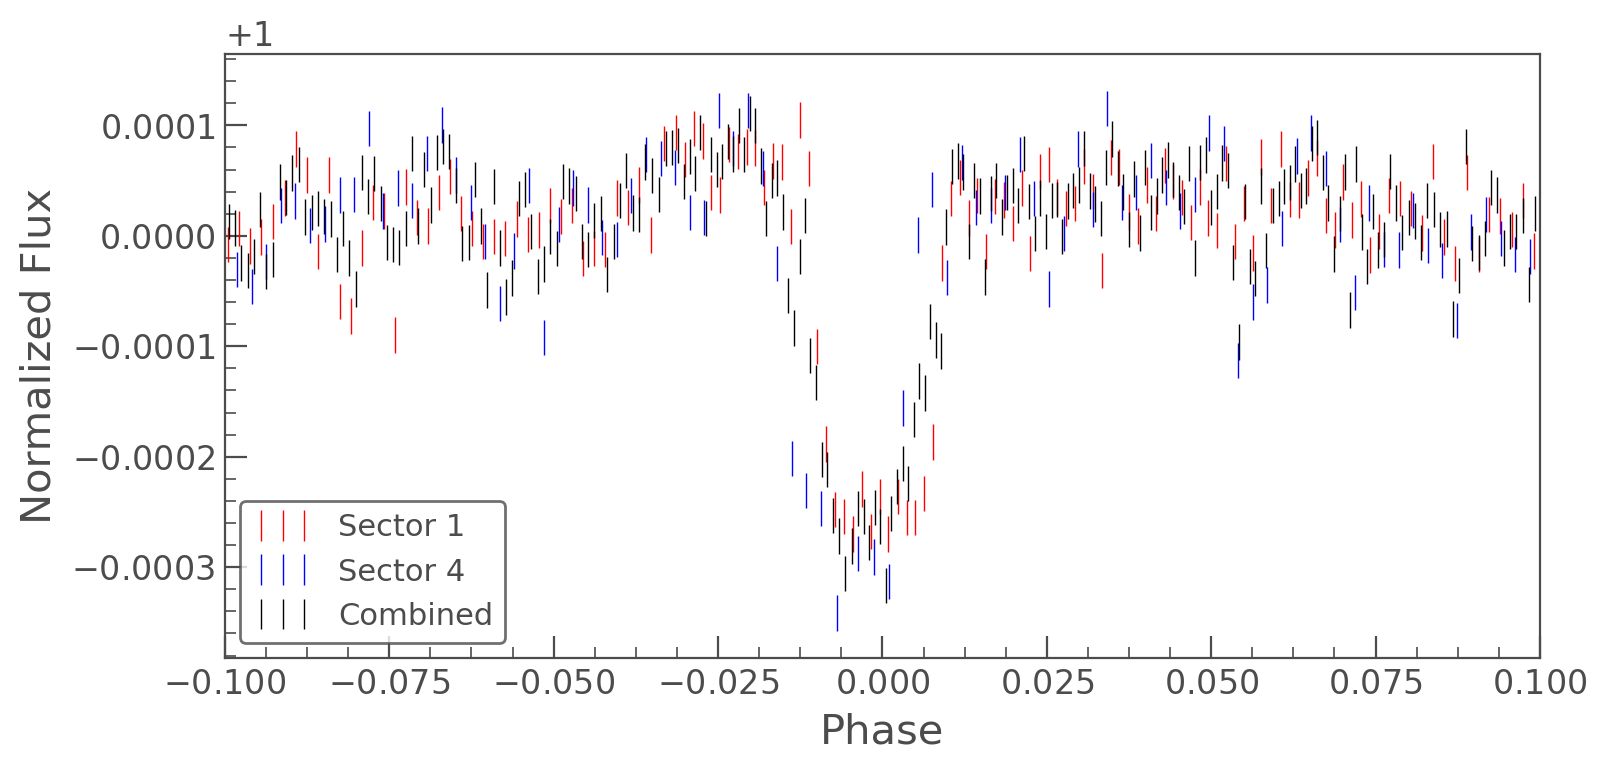

In [200]:
period = 6.27
t0 = 1325.504

ax = corr1.fold(period, t0).bin(30).errorbar(c='r', label='Sector 1')
corr2.fold(period, t0).bin(30).errorbar(ax=ax, c='b', label='Sector 4')
lc.fold(period, t0).bin(30).errorbar(ax=ax, c='k', label='Combined')
plt.xlim(-0.1, 0.1)

It looks like there is a slight offset between the transit times of Sector 1 and Sector 4. This could indicate that our transit ephemeris is not precise enough. If you increase the precision of the `period` and `t0` estimate, either by looking online or by using the `BLSPeriodogram` class in light curve, these transits will overlap.